# GSoC Coding challenge

### [Bilingual dictionary enrichment via graph completion](http://wiki.apertium.org/wiki/Ideas_for_Google_Summer_of_Code/Bilingual_dictionary_enrichment_via_graph_completion) 
### [Proposal](http://wiki.apertium.org/wiki/User:GD/proposal)

1. Choose attributes: lemma, language, POS
2. Choose id
3. Create graph
4. Find similarities \ dissimilarities
5. Accuracy

## TO DO

1. Code automatic extraction (from file names)
2. LR - RL differentiation
3. 

For toy-task it is possible to use Networkx (as it is available on Windows), but for general project it is more wisely to use powerful Graph-tool.

In [7]:
import networkx as nx

In [8]:
import matplotlib.pyplot as plt

In [9]:
import warnings
warnings.filterwarnings("ignore")

Let's take 4 strongly connected languages: Spanish, Catalan, French, English. I know French and English as foreign languages and Catalan an Spanish have their own pair so it will be easy to check results.

1. Spanish - Catalan
https://raw.githubusercontent.com/apertium/apertium-spa-cat/e871fb935e5f2d70572b8253431dde148f81f935/apertium-spa-cat.spa-cat.dix
2. French - Catalan
https://raw.githubusercontent.com/apertium/apertium-fra-cat/e388359e3c5e0753507098b1195079350523cae8/apertium-fra-cat.fra-cat.dix
3. English - Catalan
https://raw.githubusercontent.com/apertium/apertium-eng-cat/1d7c0dc28a57d5b57c5eb650f4e5b752b2140345/apertium-eng-cat.eng-cat.dix
4. English - Spanish
https://raw.githubusercontent.com/apertium/apertium-en-es/d0a72e428a23081aaf479d00f30d63053a149cce/apertium-en-es.en-es.dix
5. French - Spanish
https://raw.githubusercontent.com/apertium/apertium-fr-es/7901047303da621a1695b4a0df9a30e3c8418404/apertium-fr-es.fr-es.dix

In [24]:
LANG = nx.Graph()

In [26]:
elist = [('ES', 'CA'), ('FR', 'CA'), ('EN', 'CA'), ('FR', 'ES'), ('EN','ES')]

In [27]:
LANG.add_edges_from(elist)

In [28]:
LANG.nodes()

['ES', 'CA', 'FR', 'EN']

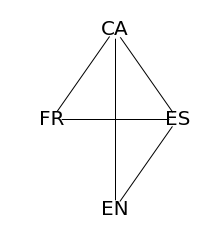

In [33]:
plt.subplot(121)
nx.draw_shell(LANG, with_labels = True, font_size = 20, node_color = 'white')
plt.show()

##  Data

In [10]:
import xml.etree.ElementTree as ET
import requests

Class Word for words that have lemma, lang and POS infromation

In [72]:
class Word:
    def __init__(self, lemma, lang, pos):
        self.lemma = lemma
        self.lang = lang
        self.pos = pos
    
    def __str__(self):
        return (str(self.lang)+'_'+str(self.lemma)+'_'+str(self.pos))
    
    def __eq__(self, other):
        return self.lemma == other.lemma and self.lang == other.lang and self.pos == other.pos
    
    def __hash__(self):
        return hash(str(self))

List of files to load (4 languages)

In [33]:
list_of_files = [(('FR','CA'), 'https://raw.githubusercontent.com/apertium/apertium-fra-cat/e388359e3c5e0753507098b1195079350523cae8/apertium-fra-cat.fra-cat.dix'),
                (('EN','CA'), 'https://raw.githubusercontent.com/apertium/apertium-eng-cat/1d7c0dc28a57d5b57c5eb650f4e5b752b2140345/apertium-eng-cat.eng-cat.dix'),
                (('FR','ES'), 'https://raw.githubusercontent.com/apertium/apertium-fr-es/7901047303da621a1695b4a0df9a30e3c8418404/apertium-fr-es.fr-es.dix'),
                (('EN','ES'), 'https://raw.githubusercontent.com/apertium/apertium-en-es/d0a72e428a23081aaf479d00f30d63053a149cce/apertium-en-es.en-es.dix')
                ]

Set empty dictionary:

In [53]:
def set_dicts(list_of_files):
    total_dict = {}
    for i in list_of_files:
        if i[0][0] not in total_dict:
            total_dict[i[0][0]] = set()
        if i[0][1] not in total_dict:
            total_dict[i[0][1]] = set()
    return total_dict

In [97]:
total_dict = set_dicts(list_of_files)

In [55]:
total_dict

{'CA': set(), 'EN': set(), 'ES': set(), 'FR': set()}

### Parse dictionary

The simpliest version (take left and right word in bidix)

In [98]:
def parse_dictionary(tree, l1, l2):
    global total_dict, G
    for i in tree.find('section').findall('e'):
        try:
            w1 = i.find('p').find('l')
            w2 = i.find('p').find('r')
            if w1.text != None and w2.text != None:
                w1 = Word(w1.text, l1, w1.find('s').attrib['n'])
                if w1 not in total_dict[l1]:
                    total_dict[l1].add(w1)
                    G.add_node(w1)
                w2 = Word(w2.text, l2, w2.find('s').attrib['n'])
                if w2 not in total_dict[l2]:
                    total_dict[l2].add(w2)
                    G.add_node(w2)
                G.add_edge(w1,w2)
        except:
            pass

General function that loads data by the information in list_of_files

In [99]:
def load_dict (list_of_files):
    for pair in list_of_files:
        link = pair[1]
        l1 = pair[0][0]
        l2 = pair[0][1]
        response = requests.get(link)
        parse_dictionary(ET.fromstring(response.content), l1, l2)

Create an empty graph

In [100]:
G = nx.Graph()

Run loading function

In [101]:
load_dict (list_of_files)

In [102]:
len(G.nodes())

162223

In [103]:
len(G.edges())

131437

In [104]:
Word('lemma', 'FR','n') == Word('lemma','FR','n')

True

In [106]:
for i in nx.descendants(G, Word('first', 'EN','adj')):
    print (i)

ES_primer_adj
ES_más_adj
EN_foremost_adj
ES_primo_adj
CA_primer_adj
FR_premier_adj
EN_prime_adj
ES_primero_adj


In [107]:
import numpy as np

In [108]:
def filter_lang(x, target_lang):
    if x.lang == target_lang:
        return x

In [109]:
filter_lang = np.vectorize(filter_lang)

In [181]:
filter_lang(list(nx.descendants(G, Word('first', 'EN','adj'))), 'CA')

array([None, None, None, None,
       <__main__.Word object at 0x000001FDB4CD5CC0>, None, None, None],
      dtype=object)

In [191]:
def get_answers(word, target_lang):
    all_w = filter_lang(list(nx.descendants(G, Word('first', 'EN','adj'))), target_lang)
    all_w = filter(None, all_w.tolist())
    return (list(all_w))
    #print (all_w)

In [192]:
get_answers(Word('first', 'EN','adj'), 'CA')

In [193]:
get_answers(Word('first', 'EN','adj'), 'CA')

In [194]:
for i in get_answers(Word('first', 'EN','adj'), 'CA'):
    print (i)

CA_primer_adj
